<a href="https://colab.research.google.com/github/chupati/disasterdetection/blob/master/Disaster_Detection_From_Social_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Detecting disaster events from twitter

This program uses Natural Laguage Processing (NLP) and Machine Learning to train two classification algorithms, Random Forest and SVM.  Upon completing training, the two algorithms will be able to predict if a twitter post is a disaster related event. 

**Import Libraries**

In [0]:
import pandas as pd
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from google.colab import files
import textwrap
import numpy as np
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score, matthews_corrcoef

**Import Data**

Upload Comma Delimited File (.CSV). 

Download the file from the link to your computer and open back up using the "Choose Files" button.

[Social Network Disaster Data (CSV)](https://raw.githubusercontent.com/chupati/disasterdetection/master/socialmedia-disaster-tweets-DFE-utf8.csv)


In [40]:


uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving socialmedia-disaster-tweets-DFE-utf8.csv to socialmedia-disaster-tweets-DFE-utf8 (1).csv
User uploaded file "socialmedia-disaster-tweets-DFE-utf8.csv" with length 2213376 bytes


**Data Pre-processing**

The following code checks that each line in the CSV file is in a utf8 format. Note that the Pandas library will fail to read non utf8 lines. 

In [41]:
bad_lines = 0
total_lines = 0
f = open('socialmedia-disaster-tweets-DFE-utf8.csv', encoding='utf-8')
for line in f:
    try:
        line.encode('utf-8')
    except UnicodeDecodeError:
        bad_lines += 1
    total_lines += 1
f.close()
print("Total Lines read:", total_lines, '\n', "Total Non UTF8 lines read:", bad_lines)  #check for non utf8 formatted twitter messages (bad lines)

Total Lines read: 12267 
 Total Non UTF8 lines read: 0


**Data Processing**

Using the Pandas library, the following code loads the CSV data into a dataframe and prints out dataframe statistics. A pandas dataframe is a datatypes that holds data in cells and columns. 


NOTE: The columns listed here are not used as features (direct inputs to the ML model); However, "choose_one:confidence" is used to create a new feature for the ML model. 

In [42]:
data = pd.read_csv('socialmedia-disaster-tweets-DFE-utf8.csv', delimiter=',')
data.describe()

,_unit_id,_trusted_judgments,choose_one:confidence,tweetid,userid
count,1.087600e+04,10876.000000,10876.000000,1.087600e+04,1.078900e+04
mean,7.782503e+08,6.022527,0.842037,6.240055e+17,1.231422e+09
std,3.200574e+03,10.463834,0.168086,5.603918e+16,1.167599e+09
min,7.782438e+08,3.000000,0.334200,1.000000e+00,3.840000e+03
25%,7.782475e+08,5.000000,0.714900,6.290590e+17,1.870027e+08
50%,7.782503e+08,5.000000,0.804900,6.290920e+17,6.342173e+08
75%,7.782530e+08,5.000000,1.000000,6.292342e+17,2.416228e+09
max,7.782611e+08,157.000000,1.000000,6.293650e+17,3.404474e+09


**Model Setup - Defining Labels for train and test phases**

Label = 0    Non-Disaster

Label = 1    Disaster

The following code adds **target** column to Pandas datagram.  A target is the value we like the ML model to predict.  The target is defined with a 95% threshold confidence. 

In [43]:
data['target'] = 0
data.loc[(data['choose_one'] == 'Relevant') & (data['choose_one:confidence'] > 0.95), ['target']] = 1
data.describe()

,_unit_id,_trusted_judgments,choose_one:confidence,tweetid,userid,target
count,1.087600e+04,10876.000000,10876.000000,1.087600e+04,1.078900e+04,10876.000000
mean,7.782503e+08,6.022527,0.842037,6.240055e+17,1.231422e+09,0.208533
std,3.200574e+03,10.463834,0.168086,5.603918e+16,1.167599e+09,0.406278
min,7.782438e+08,3.000000,0.334200,1.000000e+00,3.840000e+03,0.000000
25%,7.782475e+08,5.000000,0.714900,6.290590e+17,1.870027e+08,0.000000
50%,7.782503e+08,5.000000,0.804900,6.290920e+17,6.342173e+08,0.000000
75%,7.782530e+08,5.000000,1.000000,6.292342e+17,2.416228e+09,0.000000
max,7.782611e+08,157.000000,1.000000,6.293650e+17,3.404474e+09,1.000000


**Data Exploration**

Get a count of the tweets labeled as disasters in the data.  Notice that the low count suggest tha disaster labeled tweets are a minority class. 

In [44]:
disastercount = data['target'].sum() 
print(disastercount, ' out of ', data.shape[0] )

2268  out of  10876


**Sample Twitter messages** (TODO: NEED TO UPDATE CODE)

The following code prints sample tweets that are labeled as disasters or not labeled at all (to be considered non-disasters). 


In [45]:
y = data['target']  #Labels
x = data['text']    
for line in x:
    print(line)
    break

Just happened a terrible car crash


**Tokenizing (Breaking up twitter messages into words)**

The Tweet Tokenizer libray is used here to create list of tokens (i.e. hastags, words, or mentions). 


In [46]:
document_frequencies = dict()
term_index = dict()
token_counts = dict()
token_disasters = dict()
tokenizer = TweetTokenizer()
token_count = 0
index = 0
for index, row in data.iterrows():
    tokens = tokenizer.tokenize(row['text'])
    target = row['target']
    document_terms = set()
    for token in tokens:
        if token.lower() in token_counts:
            token_counts[token.lower()] += 1
            if not(token.lower() in document_terms):
              document_frequencies[token.lower()] += 1
              document_terms.add(token.lower())
        else:
            token_counts[token.lower()] = 1
            document_frequencies[token.lower()] = 1
            document_terms.add(token.lower())
        if token.lower() in token_disasters:
            token_disasters[token.lower()] += target
        else:
            token_disasters[token.lower()] = target
        token_count += 1

print('Token Count: ', token_count)

Token Count:  183921


**Splitting the dataset **

The following code splits the dataset into an 80/20 split. 80% of the data is used for training and 20% is used for testing. 

In [47]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print('Text Observations (X) and Disaster Labels (y) for TRAIN set')
print('X_train: ', X_train.shape)
print('y_train', y_train.shape, '\n')

print('Text Observations (X) and Disaster Labels (y) for TEST set')
print('X_test:', X_test.shape)
print('y_test', y_test.shape)

Text Observations (X) and Disaster Labels (y) for TRAIN set
X_train:  (8700,)
y_train (8700,) 

Text Observations (X) and Disaster Labels (y) for TEST set
X_test: (2176,)
y_test (2176,)


**Generate Document Frequencies**

A document is an NLP term for one unit of text. In our case, one tweet is represented as one document.

In [48]:
token_counts = dict()
x_train_disaster_probabilities = list()
N = x.shape[0]
print('N: ', N)
p_y = np.sum(y)/N
print('p(y) =', p_y)
min_pmi = np.log2(1e-10)  # Because np.log2(0) == -inf
neutral_pmi = np.log2(0.5)

x_train_features = np.zeros((X_train.shape[0], 7))
x_train_features[:, :] = neutral_pmi
row_index = 0
for row in X_train:
    #print(row)
    dedented_text = textwrap.dedent(row).strip()
    #print(dedented_text)
#     for width in [ 80]:
#         #print ('%d Columns:\n' % width)
#         print ('Twitter message:', '\"%s\"' % textwrap.fill(dedented_text, width=width))

    tokens = tokenizer.tokenize(row)
    disaster_probabilities = list()
    disaster_probabilities_round = list()
    pmi_values = list()
    for token in tokens:
        p_x = document_frequencies[token.lower()]/N
        p_x_y = token_disasters[token.lower()]/N
        if p_x_y == 0:
          pmi = min_pmi
        else:
          pmi = np.log2(p_x_y/(p_x * p_y))
        pmi_values.append(pmi)
        disaster_probabilities.append(p_x_y)
        disaster_probabilities_round.append(round(p_x_y, 2))
#     print(x_train_features[row_index, 0:3])
    x_train_features[row_index, 0:min(3, len(pmi_values))] = np.array(sorted(pmi_values, reverse=True)[0:min(3, len(pmi_values))])
    x_train_features[row_index, 3:(3 + min(3, len(pmi_values)))] = np.array(sorted(pmi_values)[0:min(3, len(pmi_values))])
    x_train_features[row_index, 6] = np.mean(pmi_values)

    
#     print('\n','\n', 'Disaster Text Probabilities')
#     print( disaster_probabilities_round)
#     print(x_train_features[row_index])
    row_index += 1
x_train_features

N:  10876
p(y) = 0.20853254873115115


array([[  0.20717534,   0.20717534,   0.16300411, ..., -33.21928095,
        -33.21928095,  -6.28697595],
       [  0.21532221,   0.20717534,  -0.11627799, ..., -33.21928095,
        -33.21928095, -13.5187032 ],
       [  0.74118174,  -0.18275659,  -0.22186173, ..., -33.21928095,
        -33.21928095, -16.73298342],
       ...,
       [  1.87463239,   1.20821625,   0.65679345, ..., -33.21928095,
        -33.21928095, -11.71079809],
       [  0.67669301,   0.46835193,   0.20717534, ..., -33.21928095,
         -2.08787705,  -4.74152397],
       [  2.26165551,   2.26165551,   1.81419653, ...,  -1.43878421,
         -0.36637571,   0.65453906]])

In [49]:
from sklearn.svm import SVC
clf = SVC(gamma='auto', probability=True)
clf.fit(x_train_features, y_train)
clf.score(x_train_features, y_train)

0.9919540229885058

In [50]:
x_test_features = np.zeros((X_test.shape[0], 7))
x_test_features[:, :] = neutral_pmi
row_index = 0
for row in X_test:
    #print(row)
    dedented_text = textwrap.dedent(row).strip()
    #print(dedented_text)
#     for width in [ 80]:
#         #print ('%d Columns:\n' % width)
#         print ('Twitter message:', '\"%s\"' % textwrap.fill(dedented_text, width=width))

    tokens = tokenizer.tokenize(row)
    disaster_probabilities = list()
    disaster_probabilities_round = list()
    pmi_values = list()
    for token in tokens:
        p_x = document_frequencies[token.lower()]/N
        p_x_y = token_disasters[token.lower()]/N
        if p_x_y == 0:
          pmi = min_pmi
        else:
          pmi = np.log2(p_x_y/(p_x * p_y))
        pmi_values.append(pmi)
        disaster_probabilities.append(p_x_y)
        disaster_probabilities_round.append(round(p_x_y, 2))
#     print(x_train_features[row_index, 0:3])
    x_test_features[row_index, 0:min(3, len(pmi_values))] = np.array(sorted(pmi_values, reverse=True)[0:min(3, len(pmi_values))])
    x_test_features[row_index, 3:(3 + min(3, len(pmi_values)))] = np.array(sorted(pmi_values)[0:min(3, len(pmi_values))])
    x_test_features[row_index, 6] = np.mean(pmi_values)

    
#     print('\n','\n', 'Disaster Text Probabilities')
#     print( disaster_probabilities_round)
#     print(x_train_features[row_index])
    row_index += 1
x_test_features

array([[  0.88968673,   0.77929282,   0.67669301, ..., -33.21928095,
        -33.21928095, -10.15099345],
       [  1.43158051,   0.53272724,   0.37291226, ..., -33.21928095,
        -33.21928095, -20.80623939],
       [  1.26165551,   1.08609151,   0.68073984, ..., -33.21928095,
        -33.21928095,  -8.60014701],
       ...,
       [  1.20821625,   0.63052283,   0.30865299, ..., -33.21928095,
        -33.21928095, -13.20307508],
       [  1.41777471,  -0.06027258,  -0.07742504, ..., -33.21928095,
         -2.34320655,  -7.1622824 ],
       [  1.08609151,   0.57762888,   0.34517887, ..., -33.21928095,
        -33.21928095, -12.64297438]])

In [51]:
clf.score(x_test_features, y_test)

0.9898897058823529

In [52]:
y_preds = clf.predict(x_test_features)
print('Accuracy: ', accuracy_score(y_test, y_preds))
print('Matthew\'s correlation coefficient: ', matthews_corrcoef(y_test, y_preds))
print('F1 Score: ', f1_score(y_test, y_preds))

Accuracy:  0.9898897058823529
Matthew's correlation coefficient:  0.9706413141100229
F1 Score:  0.977035490605428


In [57]:
scores = clf.predict_proba(x_test_features)
fpr, tpr, thresholds = roc_curve(y_test, scores[:, 1])
auc = roc_auc_score(y_test, scores[:, 1])
print('AUC: ', auc)

AUC:  0.9967399981158923


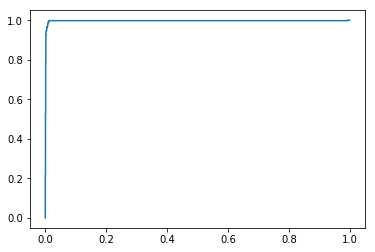

In [59]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)

plt.show()

**Deployment**

* Save the model
* Save the method for creating features - refactor into a class




In [60]:
from sklearn.externals import joblib
joblib.dump(clf, 'clf.joblib')

['clf.joblib']

In [0]:
class FeatureGeneration(object):
  def __init__(self):
    self.N = None
    self.p_y = None
    self.document_frequencies = dict()
    self.term_index = dict()
    self.token_counts = dict()
    self.token_disasters = dict()
    
  def fit(self, data):
    """
    Takes a pandas data frame and fits a corpus
    """
    tokenizer = TweetTokenizer()
    token_count = 0
    index = 0
    for index, row in data.iterrows():
        tokens = tokenizer.tokenize(row['text'])
        target = row['target']
        document_terms = set()
        for token in tokens:
            if token.lower() in self.token_counts:
                self.token_counts[token.lower()] += 1
                if not(token.lower() in document_terms):
                  self.document_frequencies[token.lower()] += 1
                  document_terms.add(token.lower())
            else:
                self.token_counts[token.lower()] = 1
                self.document_frequencies[token.lower()] = 1
                document_terms.add(token.lower())
            if token.lower() in self.token_disasters:
                self.token_disasters[token.lower()] += target
            else:
                self.token_disasters[token.lower()] = target
            token_count += 1
    self.N = len(data)
    self.p_y = np.sum(data['target'])/self.N
  
  def transform(self, x):
    """
    Transform text into input features
    """
    min_pmi = np.log2(1e-10)  # Because np.log2(0) == -inf
    neutral_pmi = np.log2(0.5)
    x_features = np.zeros((x.shape[0], 7))
    x_features[:, :] = neutral_pmi
    row_index = 0
    tokenizer = TweetTokenizer()
    for row in x:
        #print(row)
        dedented_text = textwrap.dedent(row).strip()
        #print(dedented_text)
    #     for width in [ 80]:
    #         #print ('%d Columns:\n' % width)
    #         print ('Twitter message:', '\"%s\"' % textwrap.fill(dedented_text, width=width))

        tokens = tokenizer.tokenize(row)
        disaster_probabilities = list()
        disaster_probabilities_round = list()
        pmi_values = list()
        for token in tokens:
            p_x = self.document_frequencies[token.lower()]/self.N
            p_x_y = self.token_disasters[token.lower()]/self.N
            if p_x_y == 0:
              pmi = min_pmi
            else:
              pmi = np.log2(p_x_y/(p_x * p_y))
            pmi_values.append(pmi)
            disaster_probabilities.append(p_x_y)
            disaster_probabilities_round.append(round(p_x_y, 2))
    #     print(x_train_features[row_index, 0:3])
        x_features[row_index, 0:min(3, len(pmi_values))] = np.array(sorted(pmi_values, reverse=True)[0:min(3, len(pmi_values))])
        x_features[row_index, 3:(3 + min(3, len(pmi_values)))] = np.array(sorted(pmi_values)[0:min(3, len(pmi_values))])
        x_features[row_index, 6] = np.mean(pmi_values)


    #     print('\n','\n', 'Disaster Text Probabilities')
    #     print( disaster_probabilities_round)
    #     print(x_train_features[row_index])
        row_index += 1
    return x_features

In [70]:
feature_generator = FeatureGeneration()
feature_generator.fit(data)
joblib.dump(feature_generator, 'feature_generator.joblib')

['feature_generator.joblib']

In [76]:
x_train_features = feature_generator.transform(X_train)

clf = SVC(gamma='auto', probability=True)
clf.fit(x_train_features, y_train)
clf.score(x_train_features, y_train)

0.9919540229885058